In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="qwen-qwq-32b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='\n<think>\nOkay, the user said "Hello". I need to respond appropriately. Let me think. Since it\'s a greeting, I should keep it friendly and open. Maybe say "Hello! How can I assist you today?" That sounds good. It\'s polite and invites them to state their needs. I should make sure there are no typos. Yep, looks perfect. Send it.\n</think>\n\nHello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 89, 'prompt_tokens': 11, 'total_tokens': 100, 'completion_time': 0.220918719, 'prompt_time': 0.007442421, 'queue_time': 0.32302499100000004, 'total_time': 0.22836114}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_98b01f25b2', 'finish_reason': 'stop', 'logprobs': None}, id='run--e9c88c7c-0116-43a5-82f3-5d9b60e8e17d-0', usage_metadata={'input_tokens': 11, 'output_tokens': 89, 'total_tokens': 100})

In [3]:
from typing_extensions import Literal
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage
from typing_extensions import TypedDict

class Route(BaseModel):
    step:Literal["work","personal","urgent"]=Field(description="The Type of task")


In [4]:
task = llm.with_structured_output(Route)

In [5]:
class State(TypedDict):
    input:str
    category:str
    output:str


def work_task(state : State):
    return {"output":f"Your task is to {state['input']}"}

def personal_task(state : State):
    return {"output":f"Your task is to {state['input']}"}

def urgent_task(state : State):
    return {"output":f"Your task is to {state['input']}"}

In [6]:
def llm_router(state : State):
    """Route the input to the appropriate node"""

    decision=task.invoke(
        [
            SystemMessage(
                content="Route the task to work,personal,urgent based on the user input"
            ),
            HumanMessage(content=state["input"])
        ]
    )
    return {"category":decision.step}

def router_decision(state : State):
    category = state["category"]
    if category == "work":
        return "work"
    elif category == "personal":
        return "personal"
    elif category == "urgent":
        return "urgent"

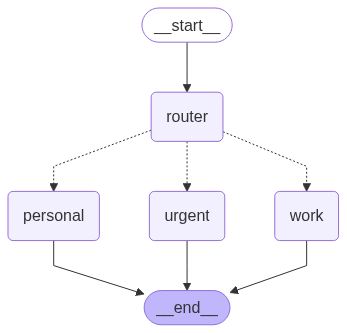

In [7]:
from langgraph.graph import StateGraph,START,END
from IPython.display import display,Image

router_builder = StateGraph(State)
router_builder.add_node("router",llm_router)
router_builder.add_node("work",work_task)
router_builder.add_node("personal",personal_task)
router_builder.add_node("urgent",urgent_task)
router_builder.add_edge(START,"router")
router_builder.add_conditional_edges("router",router_decision,{"work":"work","personal":"personal","urgent":"urgent"})
router_builder.add_edge("work",END)
router_builder.add_edge("personal",END)
router_builder.add_edge("urgent",END)

router=router_builder.compile()
display(Image(router.get_graph().draw_mermaid_png()))


In [8]:
state = router.invoke({"input":"I need to do some work immediately"})
print(state["output"])
print(state["category"])

Your task is to I need to do some work immediately
urgent


In [11]:
state = router.invoke({"input":"Need to create a PPT for my project"})
print(state["output"])
print(state["category"])

Your task is to Need to create a PPT for my project
work
